In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
complete_path = os.getcwd()
if 'nb' in complete_path:
    os.chdir("..")

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import os
import pandas as pd
import yaml
from IPython.display import clear_output
import warnings

In [4]:
from sklearn.kernel_ridge import KernelRidge
import time
from mlnrg.utils.logger import log

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from mlnrg.utils.mpl_at_utils import MPLAdjutant
from mlnrg.loader import NRGData

In [75]:
!ls -lthr results/KRR/anderson_fps*

-rw-r--r--  1 erica  staff   192M Sep  8 13:58 results/KRR/anderson_fps_alpha0_gamma0.01_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 14:00 results/KRR/anderson_fps_alpha0_gamma0.1_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 14:02 results/KRR/anderson_fps_alpha0_gamma1_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 14:08 results/KRR/anderson_fps_alpha0.01_gamma0.01_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 14:10 results/KRR/anderson_fps_alpha0.01_gamma0.1_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 14:14 results/KRR/anderson_fps_alpha0.01_gamma1_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 14:17 results/KRR/anderson_fps_alpha0.1_gamma0.01_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 14:20 results/KRR/anderson_fps_alpha0.1_gamma0.1_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 14:22 results/KRR/anderson_fps_alpha0.1_gamma1_50Ktrials.pkl
-rw-r--r--  1 erica  staff   192M Sep  8 19:03 results/KRR/anderson_fp

In [76]:
file_name = open('results/KRR/anderson_fps_alpha0.01_gamma1_50Ktrials.pkl', 'rb')
results = pickle.load(file_name)
results.keys()

dict_keys(['set', 'sampling', 'tr_set_size', 'val_set_size', 'trained_model', 'fit_time', 'sorted_errors', 'tr_cost', 'val_cost'])

In [77]:
print(results['set'])
print(results['sampling'])
print(results['tr_set_size'])
print(results['trained_model'])
print("Training score: %.5f." % results['tr_cost'])
print("Valid score: %.5f." % results['val_cost'])
print(results['fit_time'])

anderson
fps
50000
KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=1, kernel='laplacian',
            kernel_params=None)
Training score: 0.99783.
Valid score: 0.92874.
1827.101883172989


In [78]:
results['tr_set_size']

50000

In [79]:
validation_error_array = np.array(results['sorted_errors'])
raw_val_errors = validation_error_array[:,3]

In [80]:
mean_MAE_val = np.mean(raw_val_errors)
std_MAE_val  = np.std(raw_val_errors)

print(f"Avg  err: %.5f +/- %.5f" % (mean_MAE_val, std_MAE_val))
print(f"log10 Avg  err: %.5f +/- %.5f" % (np.log10(mean_MAE_val), np.log10(std_MAE_val)))
print(f"log10 median: %.5f" % np.log10(np.median(raw_val_errors)))

Avg  err: 0.02158 +/- 0.02345
log10 Avg  err: -1.66589 +/- -1.62994
log10 median: -1.83012


In [81]:
validation_errors = []
for i  in range(0, len(raw_val_errors)):
    validation_errors.append(np.log10(raw_val_errors[i]))

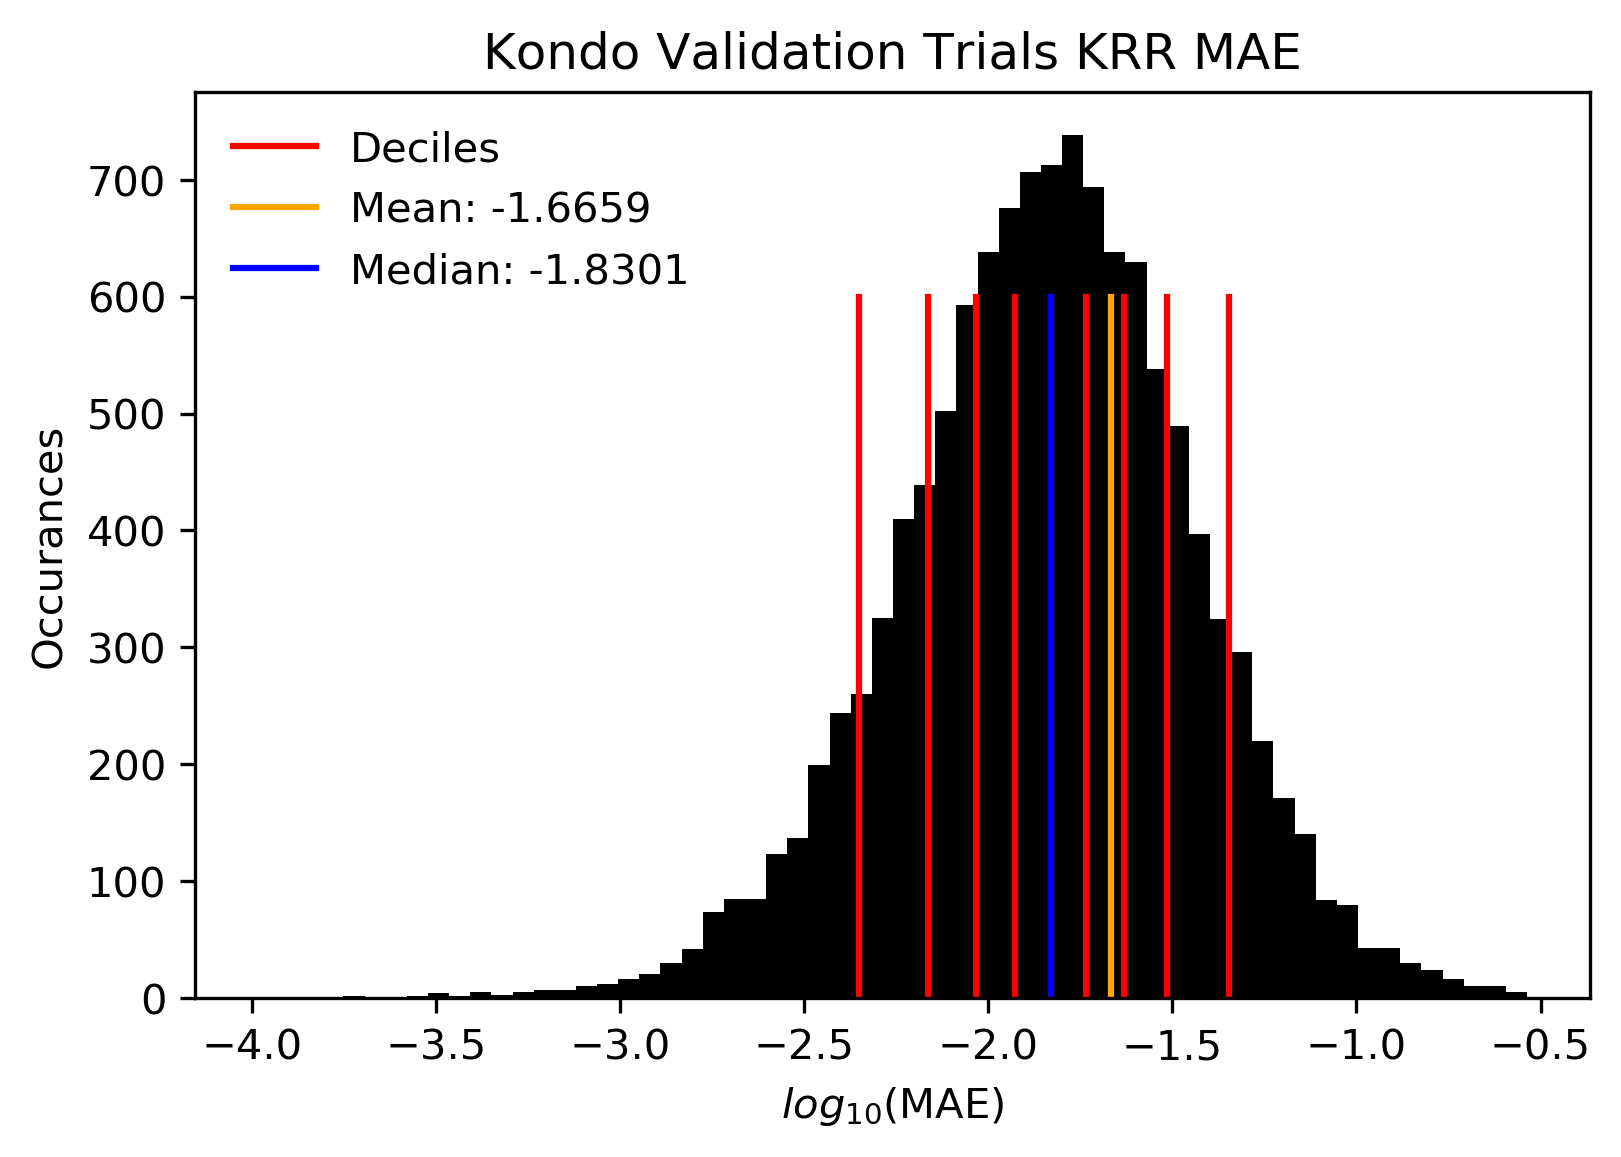

In [82]:
plt.clf()

y_Height = 0.05 * len(validation_errors)
mean = np.log10(np.mean(raw_val_errors))
median = np.log10(np.median(raw_val_errors))

plt.hist(validation_errors, bins=60, color='k')
for ii in range(1, 10):
    x = np.percentile(validation_errors, ii*10)
    plt.plot((x, x), (0, y_Height), color='r', label="Deciles" if ii == 1 else None)
plt.plot((mean, mean), (0, y_Height), color='orange', label=f"Mean: {mean:.05g}")
plt.plot((median, median), (0, y_Height), color='b', label=f"Median: {median:.05g}")

plt.title("Kondo Validation Trials KRR MAE")
plt.xlabel("$log_{10}(\mathrm{MAE})$")
plt.ylabel("Occurances")
plt.legend(loc="upper left", frameon=False)

#plt.savefig("Hist_anderson_fps_a" + str(alpha) + "_g" + str(gamma) +"_errors.png", dpi=300, bbox_inches='tight')
plt.show()

In [85]:
#original_data_set = pd.read_csv('data/Kondo_411267_trials_with_headers.csv')
#split_indexes = pickle.load(open("results/fps_files/kondo_fps.pkl", "rb"))
original_data_set = pd.read_csv('data/Anderson_599578_trials_with_headers.csv')
split_indexes = pickle.load(open("results/fps_files/anderson_fps.pkl", "rb"))

training_idx = list(split_indexes[0]['train'])
validation_idx = list(split_indexes[0]['valid'])
test_idx = list(split_indexes[0]['test'])
TEST_indexes = (original_data_set.loc[test_idx,'idx']).to_numpy()
test_idx = list(split_indexes[0]['test'])
total_trials = 50000 # Default = 50000

#### Do symlog rescaling for the entire data set IF NECESSARY. Comment or uncomment the cell below as needed!

In [86]:
# # Start with B: rescale with symlog after adjusting for B=0 cases.
# m = (original_data_set[original_data_set['B'] != 0]['B']).abs().min()
# original_data_set.loc[list((original_data_set[original_data_set['B'] == 0]).index), 'B'] = m/10

# sign_B = np.sign(original_data_set['B'])
# original_data_set.loc[:, 'B'] = sign_B * np.log10(np.abs(original_data_set.loc[:, 'B']))
# #data_set.rename(columns={'B': 'symlog10 B'}, inplace=True)

# # Now do T: rescale with regular log after adjusting for T=0 cases.
# m = (original_data_set[original_data_set['T'] != 0]['T']).abs().min()
# original_data_set.loc[list((original_data_set[original_data_set['T'] == 0]).index), 'T'] = m/10
# original_data_set.loc[:, 'T'] = np.log10(original_data_set.loc[:, 'T'])
# #data_set.rename(columns={'T': 'log10 T'}, inplace=True)

# # Now do Gamma: recale with regular log.
# original_data_set.loc[:, 'Gamma'] = np.log10(original_data_set.loc[:, 'Gamma'])
# #data_set.rename(columns={'Gamma': 'log10 Gamma'}, inplace=True)

#### Always continue here to obtain the training features for normalization and then renormalize the test set using that information.

In [87]:
unscaled_tr_features = (original_data_set.loc[training_idx[:total_trials],'U':'T']).to_numpy()
tr_targets = (original_data_set.iloc[training_idx[:total_trials], 8:]).to_numpy()

unscaled_TEST_features = (original_data_set.loc[test_idx,'U':'T']).to_numpy()
TEST_targets = (original_data_set.iloc[test_idx[:], 8:]).to_numpy()

In [88]:
mu_scaling = unscaled_tr_features.mean(axis=0)
std_scaling = unscaled_tr_features.std(axis=0)

TEST_features = (unscaled_TEST_features - mu_scaling) / std_scaling

In [89]:
trained_model = results['trained_model']

t0 = time.time()
TEST_predictions = trained_model.predict(TEST_features[:,:])
prediction_time = time.time() - t0
log.info("\nThe prediction time for %d TEST trials took %.2g seconds." %(len(TEST_features), prediction_time))

2020-10-01 17:18:31,506 INFO    [<ipython-input-89-86a46286428d>:6] 
The prediction time for 12000 TEST trials took 9.1 seconds.


In [90]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    TEST_cost = trained_model.score(TEST_features, TEST_targets)
    log.info("\nThe cost of the TEST data:\t%.5g"
     %(TEST_cost)
     )

2020-10-01 17:18:40,117 INFO    [<ipython-input-90-5e2f893a7a6e>:5] 
The cost of the TEST data:	0.93184


In [91]:
from collections import namedtuple
Result = namedtuple('Result', ['pred', 'target', 'feature', 'meta', 'name', 'mae'])

In [92]:
raw_TEST_errors = np.mean(np.abs(TEST_targets - TEST_predictions), axis=1)
sorted_TEST_errors = []
all_test_results = []
for ii in range(len(raw_TEST_errors)):
  sorted_TEST_errors.append([ii, TEST_targets[ii], TEST_predictions[ii], raw_TEST_errors[ii]])
  all_test_results.append(Result(pred=TEST_predictions[ii].tolist(),
                                 target=TEST_targets[ii].tolist(), 
                                 feature=TEST_features[ii].tolist(), 
                                 meta=None, 
                                 name=int(TEST_indexes[ii]), 
                                 mae=float(raw_TEST_errors[ii])
                                )
                         )

sorted_TEST_errors.sort(key=lambda x: x[3])

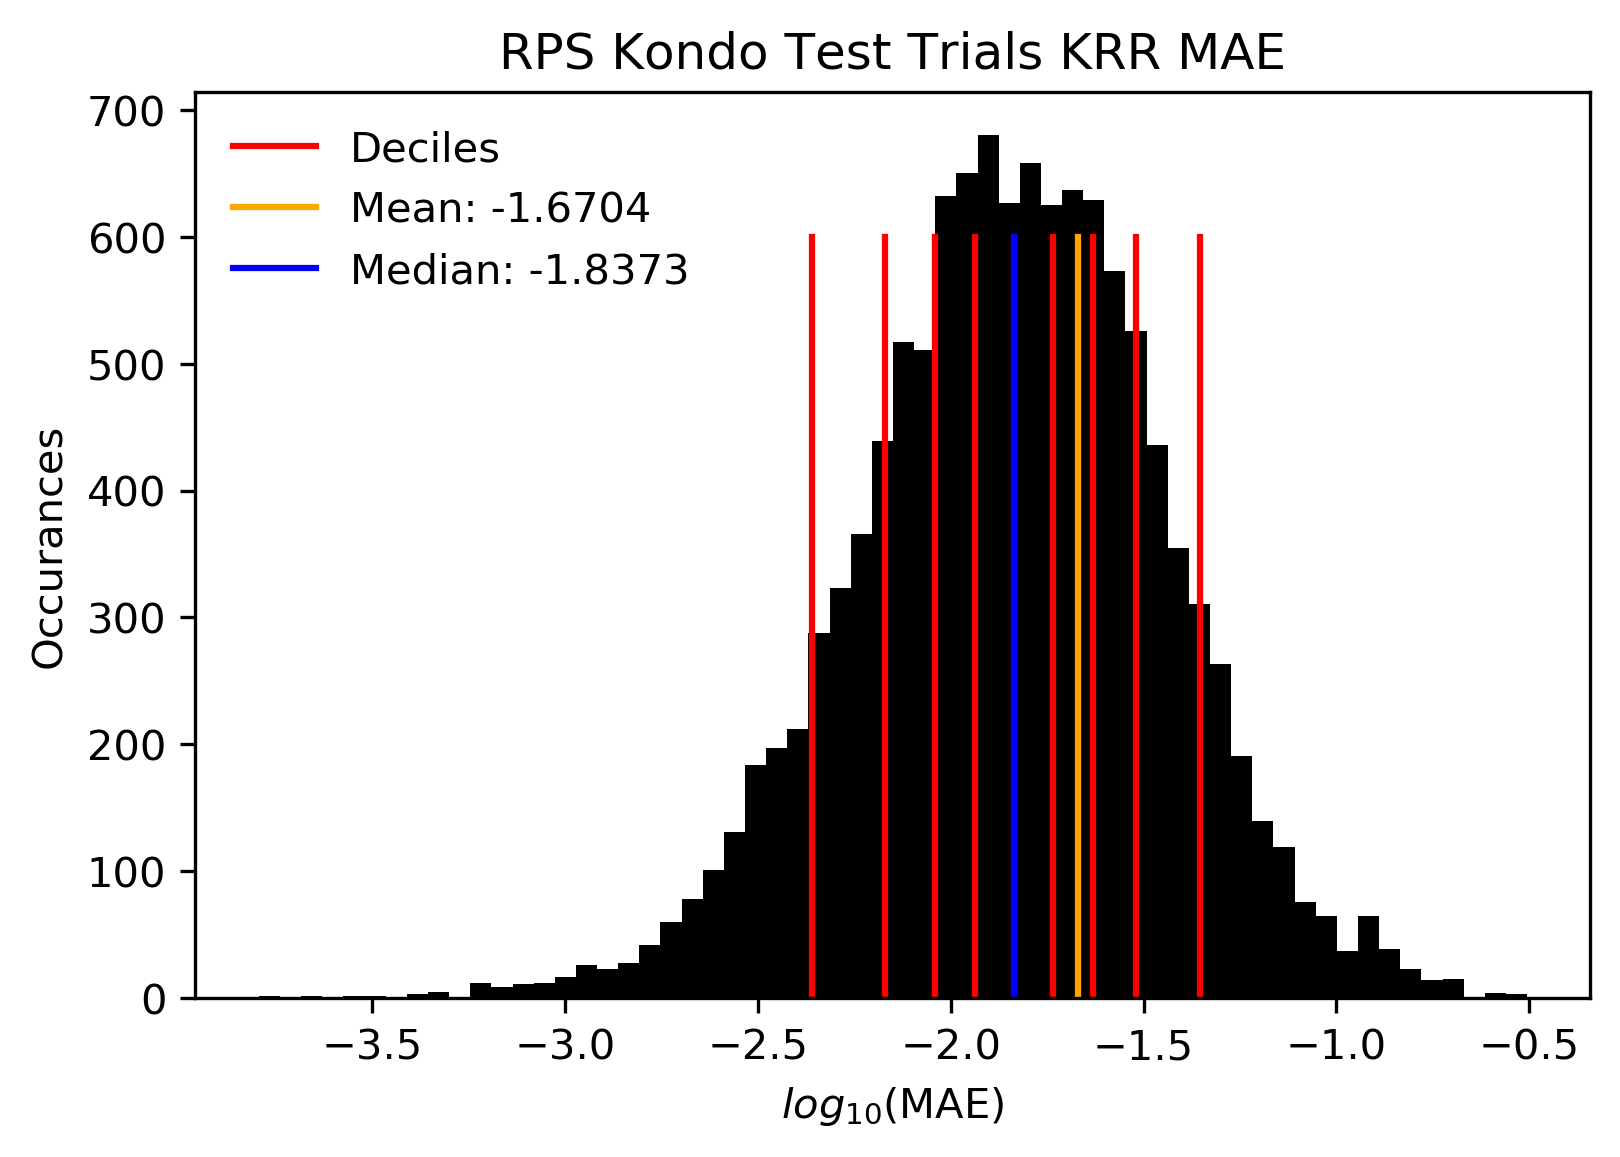

In [93]:
plt.clf()

y_Height = 0.05 * len(raw_TEST_errors)
mean = np.log10(np.mean(raw_TEST_errors))
median = np.log10(np.median(raw_TEST_errors))

plt.hist(np.log10(raw_TEST_errors), bins=60, color='k')
for ii in range(1, 10):
    x = np.percentile(np.log10(raw_TEST_errors), ii*10)
    plt.plot((x, x), (0, y_Height), color='r', label="Deciles" if ii == 1 else None)
plt.plot((mean, mean), (0, y_Height), color='orange', label=f"Mean: {mean:.05g}")
plt.plot((median, median), (0, y_Height), color='b', label=f"Median: {median:.05g}")

plt.title("RPS Kondo Test Trials KRR MAE")
plt.xlabel("$log_{10}(\mathrm{MAE})$")
plt.ylabel("Occurances")
plt.legend(loc="upper left", frameon=False)

#plt.savefig("Hist_anderson_fps_a" + str(alpha) + "_g" + str(gamma) +"_errors.png", dpi=300, bbox_inches='tight')
plt.show()

In [94]:
results['trained_model']

KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=1, kernel='laplacian',
            kernel_params=None)

In [96]:
mean_MAE_TEST_set = np.mean(raw_TEST_errors)
std_MAE_TEST_set = np.std(raw_TEST_errors)
print(f"Avg  err: %.5f +/- %.5f" % (mean_MAE_TEST_set, std_MAE_TEST_set))

Avg  err: 0.02136 +/- 0.02312


In [97]:
krr_pickle_info = {
    "dataset": "anderson",
    "N_total": 599578,
    "N_train": total_trials,
    "ker_params": {"kernel": 'laplacian', "alpha": 0.01, "gamma": 1},
    "sampler": "fps",
    "normalize_features_via_train": True,
    "scale_features_via_train": False,
    "r2_score_train": results['tr_cost'],
    "r2_score_valid": results['val_cost'],
    "r2_score_test": TEST_cost,
    "RESULTS": all_test_results 
}


pickle.dump(krr_pickle_info, open("results/KRR/FINAL_anderson_50K_fps_alpha0.01_gamma1.pkl", "wb" ))